In [4]:
%pwd

'/jet/home/mtragoza/ipython-notebooks/batman_lab'

In [279]:
%load_ext autoreload
%matplotlib inline
import sys, os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../deepxde/')
os.environ['DDEBACKEND'] = 'pytorch'
import deepxde
deepxde

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'deepxde' from '/jet/home/mtragoza/ipython-notebooks/batman_lab/../../deepxde/deepxde/__init__.py'>

# 1D inverse Helmholtz problem

We would like to solve an inverse problem for a one-dimensional Helmholtz equation:

$$
\begin{align}
    G \nabla^2 u &= -\rho \omega^2 u \\
    G \frac{\partial^2 u}{\partial x^2} &= -\rho \omega^2 u
\end{align}
$$

Where the goal is to recover the stiffness $G(x)$ given a data set of $(x, u(x))$ pairs. First, we will create a true stiffness function and solve the forward problem to obtain a wave field. Then we will compare two different methods of reconstructing the elasticity from the wave field: iterative inversion and PINNs.

## Solving the forward problem

Given some true stiffness function $G(x)$ and initial conditions, we can solve for the displacement $u(x)$ using finite differences:

$$
\begin{align}
    G \frac{\partial^2 u}{\partial x^2} &= -\rho \omega^2 u \\
    G_i \frac{u_{i+1} - 2 u_i + u_{i-1}}{h^2} &= -\rho \omega^2 u_i \\
    G_i \frac{u_{i+1} - 2 u_i + u_{i-1}}{h^2} + \rho \omega^2 u_i &= 0 \\
    \frac{u_{i+1} - 2 u_i + u_{i-1}}{h^2} + \rho \omega^2 \frac{u_i}{G_i} &= 0 \\
    \mathbf{L} \mathbf{u} + \rho \omega^2 \mathbf{G} \mathbf{u} &= 0 \\
    \left( \mathbf{L} + \rho \omega^2 \mathbf{G} \right) \mathbf{u} &= 0 \\
    \mathbf{A} \mathbf{u} &= 0
\end{align}
$$

We will use this approach to define a reference solution to the PDE for comparing inversion methods.

In [280]:
# functions for defining a 1d discrete Laplacian matrix

def tridiag(a, b, c, n, **kwargs):
    ones = torch.ones(n-1, **kwargs)
    return (
        a * torch.diag(ones, diagonal=-1) +
        b * torch.eye(n, **kwargs) + 
        c * torch.diag(ones, diagonal=1)
    )

def laplacian_matrix_1d(n_x, dx, **kwargs):
    return tridiag(1, -2, 1, n_x, **kwargs) / dx**2

def print_mat(**kwargs):
    for k, v in kwargs.items():
        v_str = repr(v).replace('\n', '\n')
        print(f'{k} = \n{v_str}')

L = laplacian_matrix_1d(6, 1)
print_mat(L=L)

L = 
tensor([[-2.,  1.,  0.,  0.,  0.,  0.],
        [ 1., -2.,  1.,  0.,  0.,  0.],
        [ 0.,  1., -2.,  1.,  0.,  0.],
        [ 0.,  0.,  1., -2.,  1.,  0.],
        [ 0.,  0.,  0.,  1., -2.,  1.],
        [ 0.,  0.,  0.,  0.,  1., -2.]])


In [281]:
# implicit method using tridiagonal linear system

def implicit_solver_1d(x, n_x, dx, G, u0, rho, omega, **kwargs):

    # set up linear system
    L = laplacian_matrix_1d(n_x, dx, **kwargs)
    G = torch.diag(1 / G[:,0])

    A = L + rho * omega**2 * G
    b = torch.zeros(n_x, **kwargs)
    
    # determine boundary nodes
    on_boundary = (torch.abs(x).max(dim=1)[0] == 1.0)
    
    # set boundary conditions
    A[on_boundary,:] = 0
    A[on_boundary,on_boundary] = 1
    b[on_boundary] = u0[on_boundary,0]

    # solve linear system    
    u = torch.linalg.solve(A, b)

    return u.reshape(-1, 1)

# define the reference solution

def solution(x, n_x, dx, rho, omega, **kwargs):
    '''
    Compute reference solution.
    '''
    # true stiffness function
    G = torch.ones((n_x, 1), **kwargs) * rho
    G = G + torch.exp(-((x+0.5)**2).sum(dim=1, keepdim=True)*100) *  rho
    G = G + torch.exp(-((x-0.5)**2).sum(dim=1, keepdim=True)*100) * -rho / 2
    
    # solve for displacement
    phi = torch.rand(1, **kwargs) * 2 * np.pi # random phase offset
    u0 = torch.sin(omega * (x - phi))
    u = implicit_solver_1d(x, n_x, dx, G, u0, rho, omega, **kwargs)

    return u, G

# define the training data set

rho = 1
omega = 4 * np.pi

def gen_train_data(n_x, **kwargs):
    '''
    Generate training data for PDE.
    '''
    x = torch.linspace(-1, 1, n_x, **kwargs)
    dx = x[1] - x[0]
    x = x.reshape(-1, 1)
    u, G = solution(x, n_x, dx, rho, omega, **kwargs)
    return x, u, G

n_train = 100 # training points

x, u_true, G_true = gen_train_data(n_train, device='cuda')

print(x.shape, u_true.shape, G_true.shape)

torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1])


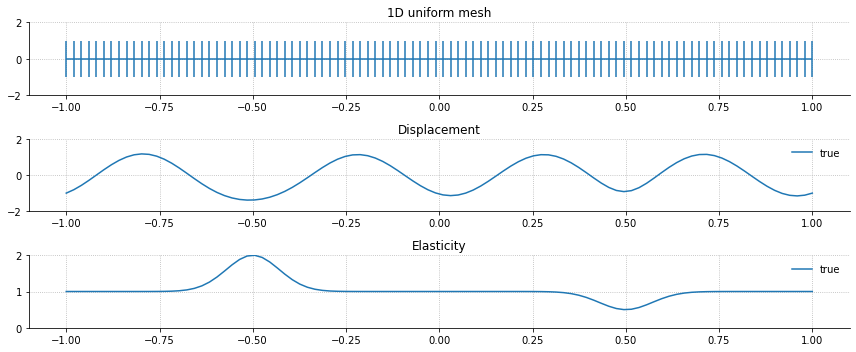

In [282]:
def plot_1d(x, us, Gs):
    
    fig, axes = plt.subplots(3, 1, figsize=(12,5))
    
    # plot mesh
    ax = axes[0]
    ax.set_title('1D uniform mesh')
    ax.hlines(0, -1, 1)
    ax.vlines(x, -1, 1)
    ax.set_ylim(-2, 2)
    
    labels = ['true', 'predicted']
    
    # plot displacement
    ax = axes[1]
    ax.set_title('Displacement')
    for u, label in zip(us, labels):
        ax.plot(x, u, label=label)
        ax.set_ylim(-2, 2)
    ax.legend(frameon=False)
        
    # plot stiffness
    ax = axes[2]
    ax.set_title('Elasticity')
    for G, label in zip(Gs, labels):
        ax.plot(x, G, label=label)
        ax.set_ylim(0, 2*rho)
    ax.legend(frameon=False)
        
    for ax in axes:
        ax.set_axisbelow(True)
        ax.grid(True, linestyle=':')

    sns.despine(fig)
    fig.tight_layout()

plot_1d(x.cpu().numpy(), [u_true.cpu().numpy()], [G_true.cpu().numpy()])

## Physics-informed neural network

We will use DeepXDE to solve the PDE inverse problem on the interval $x \in [-1, 1]$ using a neural network.

Given some candidate solution $(\hat{u}, \hat{G})$, we can rearrange the PDE to obtain a residual:

$$
\begin{align}
    G \nabla^2 u &= -\rho \omega^2 u \\
    0 &= G \nabla^2 u + \rho \omega^2 u \\
    r(\hat{u}, \hat{G} ) &= \hat{G} \nabla^2 \hat{u} + \rho \omega^2 \hat{u}
\end{align}
$$

We will train a neural network to minimize this residual, subject to constraints in the form of a set of training data points of $(x, u(x))$.

In [283]:
# define the geometry (i.e. domain of x)

geom = deepxde.geometry.Interval(-1, 1)
print(geom)
print(f'dim = {geom.dim}\nbbox = {geom.bbox}\ndiam = {geom.diam}')

# define the residual of the PDE

def pde(x, u_G):
    '''
    Compute PDE residual.
    '''
    u, G = u_G[:,0:1], u_G[:,1:2]
    u_xx = deepxde.grad.hessian(
        ys=u, # output tensor of shape (batch_size, dim_y)
        xs=x, # input tensor of shape (batch_size, dim_x)
        component=None, # index into dim_y
        i=0, j=0 # indices into dim_x
    )
    return G * u_xx + rho * omega**2 * u

# define the boundary conditions (i.e. training data)

point_set = deepxde.icbc.PointSetBC(
    points=x.cpu().numpy(), # array of points where target values are known
    values=u_true.cpu().numpy(), # array of values of the exact solution
    component=0
)

# data combines the geometry, PDE residual, and boundary conditions

n_domain = 200 # random samples in domain for PDE loss
n_test  = 1000 # test evaluation points

data = deepxde.data.PDE(
    geometry=geom, # an instance of Geometry
    pde=pde, # a global PDE or a list of PDEs
    bcs=[point_set], # a boundary condition or list of boundary conditions
    num_domain=n_domain,
    anchors=x.cpu().numpy(), # array of training points in addition to num_domain and num_boundary points
    num_test=n_test # number of points sampled inside the boundary the domain for testing
)

dim = 1
bbox = (array([-1]), array([1]))
diam = 2


In [284]:
# define the neural network architecture

n_layers = 5
n_hidden = 32
activ_fn = 'sin'

net = deepxde.nn.PFNN(
    layer_sizes=[1] + [[n_hidden, n_hidden]] * (n_layers-1) + [2],
    activation=activ_fn,
    kernel_initializer="Glorot uniform"
)
net

PFNN(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): Linear(in_features=1, out_features=32, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
    )
    (4): ModuleList(
      (0): Linear(in_features=32, out_features=1, bias=True)
      (1): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [285]:
model = deepxde.Model(data, net)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-5, 1]
)

Compiling model...
'compile' took 0.000279 s



In [286]:
loss_history, train_state = model.train(epochs=20000)

Training model...

Step      Train loss              Test loss               Test metric
0         [4.76e-03, 7.08e-01]    [4.74e-03, 7.08e-01]    []  
1000      [6.14e-04, 4.30e-04]    [6.14e-04, 4.30e-04]    []  
2000      [1.18e-04, 1.51e-04]    [1.16e-04, 1.51e-04]    []  
3000      [9.30e-05, 8.36e-05]    [9.10e-05, 8.36e-05]    []  
4000      [7.94e-05, 7.37e-05]    [7.70e-05, 7.37e-05]    []  
5000      [6.59e-05, 5.29e-05]    [6.38e-05, 5.29e-05]    []  
6000      [5.35e-05, 4.63e-05]    [5.17e-05, 4.63e-05]    []  
7000      [4.27e-05, 4.24e-05]    [4.13e-05, 4.24e-05]    []  
8000      [6.45e-05, 1.28e-04]    [6.26e-05, 1.28e-04]    []  
9000      [3.46e-05, 3.75e-05]    [3.35e-05, 3.75e-05]    []  
10000     [3.34e-05, 4.68e-05]    [3.24e-05, 4.68e-05]    []  
11000     [9.38e-05, 2.32e-04]    [9.18e-05, 2.32e-04]    []  
12000     [3.27e-05, 5.14e-05]    [3.23e-05, 5.14e-05]    []  
13000     [2.86e-05, 3.40e-05]    [2.79e-05, 3.40e-05]    []  
14000     [2.85e-05, 3.42e-05

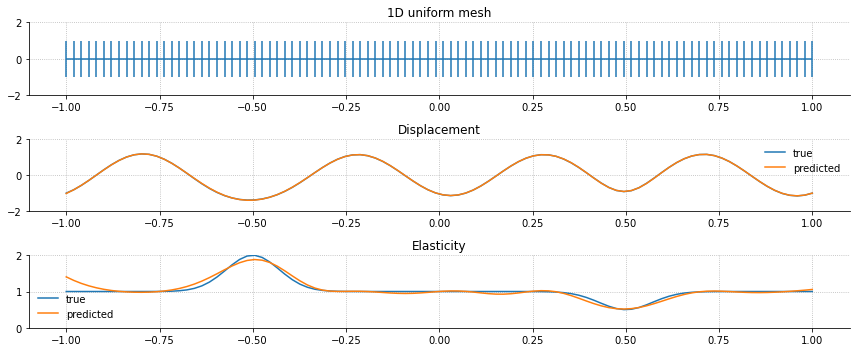

In [297]:
# view results

u_G_pred = model.predict(x.cpu())
u_pred, G_pred = u_G_pred[:, 0:1], u_G_pred[:, 1:2]

plot_1d(
    x.cpu().numpy(),
    [u_true.cpu().numpy(), u_pred],
    [G_true.cpu().numpy(), G_pred])

## Iterative method

Another method for solving the inverse problem is to formulate it as a minimization task:

$$
\begin{align}
    G^* = \operatorname{argmin}_{\hat{G}} \mathcal{L}(\hat{G})
\end{align}
$$

Where the objective being minimized could be, for instance, the sum of squared error:

$$
    \mathcal{L}(\hat{G}) = \| \hat{u}(x; \hat{G}) - u(x) \|^2
$$

Where $\hat{u}(x; \hat{G})$ denotes the wave field obtained by solving the forward problem given the stiffness estimate $\hat{G}$. Thus, the method minimizes the error between the empirical wave field and the one produced by solving the forward problem for a given estimate of the stiffness function, which are now a set of parameters.

We can derive a gradient descent update step for the stiffness parameters $\hat{G}$:

$$
    \hat{G}_{n+1} = \hat{G}_n - \alpha \nabla \mathcal{L}(\hat{G})
$$

Which requires evaluating the gradient of the displacement estimate wrt the stiffness estimate:

$$
\begin{align}
    \nabla \mathcal{L}(\hat{G}) &= \nabla \hat{u}^\top \left( \hat{u}(x; \hat{G}) - u(x) \right) \\
\end{align}
$$

A requirement for this method is that the forward solver is continuous and differentiable with respect to the input coordinates.

In [298]:
def iterative_inversion_1d(x, n_x, dx, G0, i, u, rho, omega, n_iters=5000, lr=1e-2, reg=0, **kwargs):
    
    G_pred = torch.nn.Parameter(G0)
    optimizer = torch.optim.Adam([G_pred], lr=lr)
    
    for i in range(i, i+n_iters):
        
        def closure():
            optimizer.zero_grad()
            u_pred = implicit_solver_1d(x, n_x, dx, G_pred, u, rho, omega, **kwargs)
            loss = torch.nn.functional.mse_loss(u_pred, u) + reg * torch.sum(G_pred**2)
            if (i+1) % 500 == 0:
                print(i+1, loss.item())
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
    u_pred = implicit_solver_1d(x, n_x, dx, G_pred, u, rho, omega, **kwargs)  
    return u_pred, G_pred, i

n_x = n_train
dx = x[0,0] - x[1,0]

G_pred = torch.normal(1, 0.1, (n_train, 1), device='cuda')
u_pred = implicit_solver_1d(x, n_x, dx, G_pred, u_true, rho, omega, device='cuda')
i = 0

In [299]:
u_pred, G_pred, i = iterative_inversion_1d(x, n_train, x[0,0] - x[1,0], G_pred, i, u_true, rho, omega, device='cuda')

500 0.0001902757940115407
1000 4.9460388254374266e-05
1500 2.204590964538511e-05
2000 1.2132033589296043e-05
2500 7.733241545793135e-06
3000 5.451001015899237e-06
3500 4.015780632471433e-06
4000 3.0595099360652966e-06
4500 2.3814711767045083e-06
5000 1.940685251611285e-06


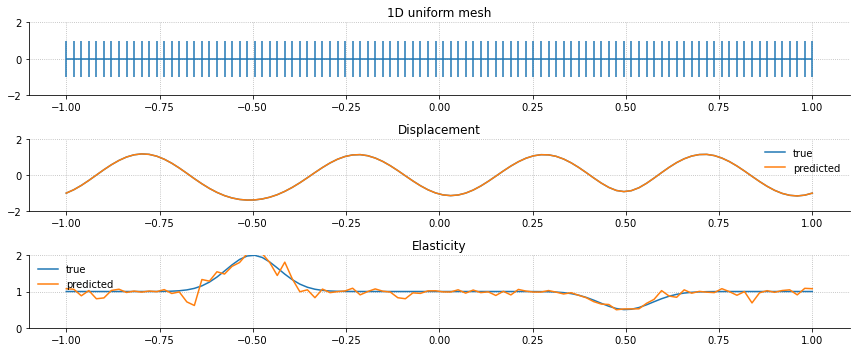

In [307]:
# view results

plot_1d(
    x.detach().cpu(),
    [u_true.detach().cpu(), u_pred.detach().cpu()],
    [G_true.detach().cpu(), G_pred.detach().cpu()]
)